# basic imports

---



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn.datasets
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory


import torchvision
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio


# import dataset

---



### mount to drive

In [2]:
## mount to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### move to testing folder and unzip if needed

In [3]:
%cd /content/gdrive/MyDrive/big data project testing/DataSet

## unzip if necessary
# !unzip DataSet.zip > /dev/null # output to null

/content/gdrive/MyDrive/big data project testing/DataSet


### split training into training/validation sets

In [4]:
## check size of training set directory
dpath = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train'
training_count = 0
for path in os.listdir(dpath):
    if os.path.isfile(os.path.join(dpath, path)):
        training_count += 1


## check size of testing set directory
dpath = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_test'
testing_count = 0
for path in os.listdir(dpath):
    if os.path.isfile(os.path.join(dpath, path)):
        testing_count += 1

## get total number of images
total_count = training_count + testing_count
print(f'number of training images: {training_count} ({int(training_count/total_count*100)}%)')
print(f'number of testing images: {testing_count} ({int(testing_count/total_count*100)}%)')


number of training images: 10359 (76%)
number of testing images: 3238 (23%)


In [5]:
## decide split size (validation = 20% of training set)
expected_val_count = 2071
print(f'expected number of validation images: {expected_val_count}')
expected_training_count = 10359
print(f'expected number of training images: {expected_training_count}')

## next: keep first 10359 images in training, move remainder to validation ##
valid_path = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_validation'
train_path = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train'

## check if validation directory exists
if not os.path.isdir(valid_path):
    ## if not, then make it
    print('generating validation set directory...')
    os.mkdir(valid_path)

## check if validation directory contains its images
valid_count = 0
for path in os.listdir(valid_path):
    if os.path.isfile(os.path.join(valid_path, path)):
        valid_count += 1

## if not, (and if training set is original) create the validation set
if valid_count == 0:
    print('adding images to validation set...')
    val = []
    for dirName, subdirList, fileList in os.walk(train_path):   ## filelist contains names of each file in training directory
        ## iterate through files in training directory
        index = 1   ## index 1 is the 1st image
        for fname in fileList:
            ## get image number
            num = fname.split('.')[0]
            ## all images after the 10359th move to validation
            if index > expected_training_count:
                val.append(fname)
                ## get old path and new path
                oldpath = train_path + '/' + fname
                newpath = valid_path + '/' + fname
                ## move the image
                shutil.move(oldpath, newpath)
            index += 1

## check again if validation directory contains its images
valid_count = 0
for path in os.listdir(valid_path):
    if os.path.isfile(os.path.join(valid_path, path)):
        valid_count += 1


## check size of training set directory
training_count = 0
for path in os.listdir(train_path):
    if os.path.isfile(os.path.join(train_path, path)):
        training_count += 1

## get total number of train/valid images
total_count = training_count + testing_count
print(f'\nnumber of training images: {training_count} ({int(training_count/total_count*100)}%)')
print(f'number of validation images: {valid_count} ({int(valid_count/total_count*100)}%)')


expected number of validation images: 2071
expected number of training images: 10359

number of training images: 10359 (76%)
number of validation images: 2589 (19%)


### view sample image

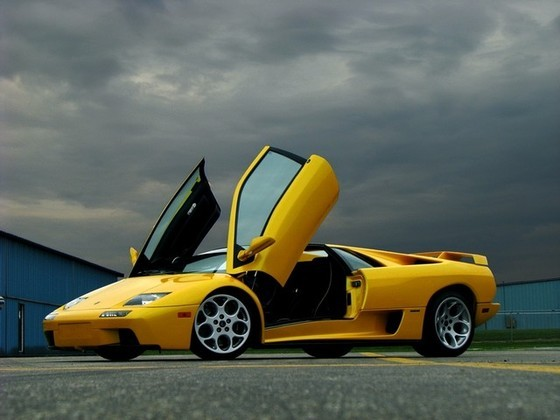

In [6]:
import tensorflow as tf
import random

val_start = 10360
val_end = 12948
img_no = random.randint(val_start, val_end)
# img = tf.keras.preprocessing.image.load_img('DataSet/images/cars_train/10359.jpg')
img = tf.keras.preprocessing.image.load_img(f'DataSet/images/cars_validation/{img_no}.jpg') ## an image in validation set
img

# create test/train/val dataframes

---



### create metadata/test/train dataframes (annots)

In [7]:
## repair value issues in train/test csv
train_data = pd.read_csv("DataSet/data/train.csv")
if train_data.loc[9998, 'fname'] == '9999.jpg':
    train_data.loc[9998, 'fname'] = '09999.jpg'
    train_data.to_csv("DataSet/data/train.csv", index=False)
# train_data.drop( columns=["Unnamed: 0"], inplace=True )
# train_data.to_csv("DataSet/data/train.csv", index=False) ## need to include index=False to avoid appending empty columns

## fix test
test_data = pd.read_csv("DataSet/data/test.csv")
if 'Unnamed: 0' in test_data.columns:
    test_data.drop( columns=["Unnamed: 0"], inplace=True )
    test_data.to_csv("DataSet/data/test.csv", index=False)

## fix metadata
metadata = pd.read_csv("DataSet/data/meta.csv")
if 'Unnamed: 0' in metadata.columns:
    metadata.drop( columns=["Unnamed: 0"], inplace=True )
    metadata.to_csv("DataSet/data/meta.csv", index=False)


In [8]:
## create dataframe object
metadata = pd.read_csv("DataSet/data/meta.csv")
print(f'METADATA:\n{metadata.head()}\n')

## create base training dataframe object
train_data_base = pd.read_csv("DataSet/data/train.csv")

# ## create train data
train_data = train_data_base.copy()[:expected_training_count] ## first (expected_training_count) rows of train_data
train_data['path'] = train_path + '/' + train_data['fname']
train_data['class'] = train_data['class'].astype(str)
print(f'TRAIN DATA:\n{train_data.head()}\n')

# ## create valid data
valid_data = train_data_base.copy()[expected_training_count:]    ## remainder of train_data
valid_data.reset_index(drop=True, inplace=True)
valid_data['path'] = valid_path + '/' + valid_data['fname']
valid_data['class'] = valid_data['class'].astype(str)
print(f'VALID DATA:\n{valid_data.head()}\n')

# ## create dataframe object
test_data = pd.read_csv("DataSet/data/test.csv")
print(f'TEST DATA:\n{test_data.head()}\n')

METADATA:
                   class_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

TRAIN DATA:
    x1   y1    x2    y2 class      fname  \
0   39  116   569   375    14  00001.jpg   
1   36  116   868   587     3  00002.jpg   
2   85  109   601   381    91  00003.jpg   
3  621  393  1484  1096   134  00004.jpg   
4   14   36   133    99   106  00005.jpg   

                                                                                           path  
0  /content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train/00001.jpg  
1  /content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train/00002.jpg  
2  /content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train/00003.jpg  
3  /content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train/00004.jpg  
4  /content/gdrive/MyDrive/big data projec

### mess with some code snippets from the team

In [9]:
## set paths
valid_path = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_validation'
train_path = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_train'
test_path = r'/content/gdrive/MyDrive/big data project testing/DataSet/DataSet/images/cars_test'

## create image generator for training
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,           # Horizontal shifts, simulating different angles
    height_shift_range=0.2,          # Vertical shifts, cars at different distances
    shear_range=0.15,                 # Shear, simulating camera angle changes
    zoom_range=0.15,                  # Zoom, simulating cars moving closer or further away
)

## get the images for training
train_imgs = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,         ## no directory since no subdirectories per class
    x_col="path",           ## column with filenames (paths) for images
    y_col="class",          ## column with class labels (strings)
    target_size=(224, 224), ## size of image
    batch_size=64,          ## adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,           ## shuffle data for better training
    seed=42,                ## for reproducibility of data shuffling and augmentations
)

## create image generator for val
val_datagen = ImageDataGenerator(
    width_shift_range=0.2,           # Horizontal shifts, simulating different angles
    height_shift_range=0.2,          # Vertical shifts, cars at different distances
    shear_range=0.15,                 # Shear, simulating camera angle changes
    zoom_range=0.15,                  # Zoom, simulating cars moving closer or further away
)

## get the images for training
val_imgs = val_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=None,         ## no directory since no subdirectories per class
    x_col="path",           ## column with filenames (paths) for images
    y_col="class",          ## column with class labels (strings)
    target_size=(224, 224), ## size of image
    batch_size=64,          ## adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,           ## shuffle data for better training
    seed=42,                ## for reproducibility of data shuffling and augmentations
)

## create a basic model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

## compile the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## add some data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## create a model with augmentation
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


Found 10359 validated image filenames belonging to 196 classes.
Found 2589 validated image filenames belonging to 196 classes.


In [10]:
## try to fit the model
# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         filepath="convnet_from_scratch.h5",
#         save_best_only=True,
#         monitor="val_loss")
# ]

# history = model.fit(
#     train_imgs,
#     epochs=20,
#     validation_data=val_imgs,
#     callbacks=callbacks)

## fit the model with augmentation
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_imgs,
    epochs=20,
    validation_data=val_imgs,
    callbacks=callbacks)
## TODO: figure out ho to use the convnet_from_scratch_with_augmentation.h5 in future cells so we don't have to refit

Epoch 1/20
162/162 [==============================] - 1888s 9s/step - loss: 0.0428 - accuracy: 0.9947 - val_loss: 0.0325 - val_accuracy: 0.9949
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


162/162 [==============================] - 217s 1s/step - loss: 0.0325 - accuracy: 0.9949 - val_loss: 0.0322 - val_accuracy: 0.9949
Epoch 3/20
162/162 [==============================] - 218s 1s/step - loss: 0.0323 - accuracy: 0.9949 - val_loss: 0.0321 - val_accuracy: 0.9949
Epoch 4/20
162/162 [==============================] - 215s 1s/step - loss: 0.0322 - accuracy: 0.9949 - val_loss: 0.0321 - val_accuracy: 0.9949
Epoch 5/20
162/162 [==============================] - 216s 1s/step - loss: 0.0322 - accuracy: 0.9949 - val_loss: 0.0321 - val_accuracy: 0.9949
Epoch 6/20
162/162 [==============================] - 216s 1s/step - loss: 0.0322 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Epoch 7/20
162/162 [==============================] - 214s 1s/step - loss: 0.0322 - accuracy: 0.9949 - val_loss: 0.0321 - val_accuracy: 0.9949
Epoch 8/20
162/162 [==============================] - 214s 1s/step - loss: 0.0321 - accuracy: 0.9949 - val_loss: 0.0320 - val_accuracy: 0.9949
Epoch 9/20

In [ ]:
# tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
#                       max_warp=0.,
#                       xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
#                                  symmetric_warp(magnitude=(-0.2, 0.2))])

# data = ImageDataLoaders.from_folder.('data/','train','valid',
#                                   ds_tfms=tfms
#                                   ,size=128,bs=64).normalize(imagenet_stats)

Found 8288 validated image filenames belonging to 196 classes.
Found 517 validated image filenames belonging to 196 classes.


ValueError: num must be an integer with 1 <= num <= 16, not 17

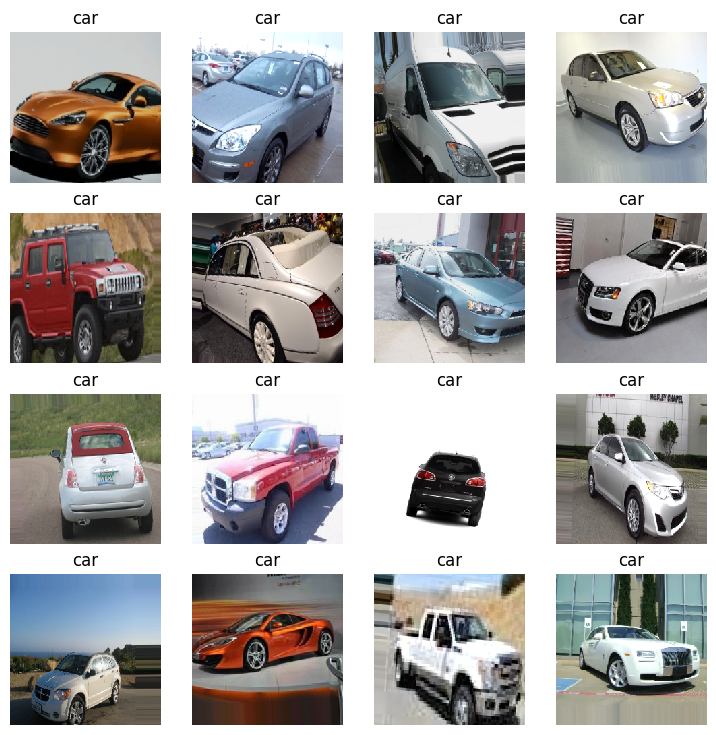

In [ ]:
## make an ImageDataGenerator for train
# train_datagen = ImageDataGenerator(
#     width_shift_range=0.2,           # Horizontal shifts, simulating different angles
#     height_shift_range=0.2,          # Vertical shifts, cars at different distances
#     shear_range=0.15,                 # Shear, simulating camera angle changes
#     zoom_range=0.15,                  # Zoom, simulating cars moving closer or further away
# )

## original generator idea
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixel values
    rotation_range=10,               # Slight rotation, assuming cars are mostly upright
    width_shift_range=0.1,           # Horizontal shifts, simulating different angles
    height_shift_range=0.1,          # Vertical shifts, cars at different distances
    shear_range=0.1,                 # Shear, simulating camera angle changes
    zoom_range=0.2,                  # Zoom, simulating cars moving closer or further away
    horizontal_flip=True,            # Flip, cars can appear in either orientation on a road
    brightness_range=[0.8,1.2],      # Brightness, different lighting conditions
    fill_mode='nearest',             # Fill mode, to handle new pixels after a shift or rotation
    validation_split=0.2,             # Use 20% of images for validation
)

## make an ImageDataGenerator for train
# valid_datagen = ImageDataGenerator()

## convert class integers to string
train_data['class'] = train_data['class'].astype(str)
valid_data['class'] = valid_data['class'].astype(str)



train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    validation_split=1.0,
    subset='training',  # Specify this is for validation data
)

## can i find a way to modify validation_split so that it doesn't divide my training data directory but notes that this is the train
## and the next is the validation?
## or just make another directory for project testing that matches our original?

## clone yolo ?



# build the train generator (data augmentation)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=valid_path,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    # shuffle=True,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    validation_split=0.0,
    subset='validation',  # Specify this is for training data
)




# train_generator.fit(train_data)

x, y = validation_generator.next()
plt.figure(figsize=(9, 9))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 4, i+1)
    plt.title('car')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")


# model = tf.keras.Sequential([
#   tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256, 3)),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(196)
# ])
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# epochs=10




In [ ]:
# images =

# img = tf.keras.preprocessing.image.load_img('DataSet/images/cars_train/00090.jpg')


In [ ]:
imgs = sklearn.datasets.load_files('DataSet/images/cars_train', shuffle='False')
# archive = tf.keras.utils.get_file(origin='DataSet/images/cars_train')

print(len(imgs['data']))


0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## trying out datagen code
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)


# train_gen = train_datagen.flow_from_directory(
#     directory=r'/Dataset/images/cars_train',
#     target_size=(150,150),
#     batch_size=32,
#     class_mode='categorical'
# )


# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [ ]:
train_data_cat = train_data.copy()
train_data_cat['class'] = train_data_cat['class'].astype('str')


image_train_data_dir = 'Dataset/images/cars_train/'
print(image_train_data_dir)
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixel values
    rotation_range=10,               # Slight rotation, assuming cars are mostly upright
    width_shift_range=0.1,           # Horizontal shifts, simulating different angles
    height_shift_range=0.1,          # Vertical shifts, cars at different distances
    shear_range=0.1,                 # Shear, simulating camera angle changes
    zoom_range=0.2,                  # Zoom, simulating cars moving closer or further away
    horizontal_flip=True,            # Flip, cars can appear in either orientation on a road
    brightness_range=[0.8,1.2],      # Brightness, different lighting conditions
    fill_mode='nearest',             # Fill mode, to handle new pixels after a shift or rotation
    validation_split=0.2             # Use 20% of images for validation
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_cat,
    directory=image_train_data_dir,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=8,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    # validation_split=0.2,
    subset='training',  # Specify this is for validation data
)


Dataset/images/cars_train/
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 12948 invalid image filename(s) in x_col="fname". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
## code "borrowed" from a github
from resnet_152 import resnet152_model

## set variables
img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
verbose = 1
batch_size = 16
num_epochs = 100000
patience = 50

## generate model
model = resnet152_model(img_height, img_width, num_channels, num_classes)


ModuleNotFoundError: No module named 'resnet_152'